In [57]:
# =============================
# FUNCTIONS for overlapping pulses 
# =============================
 
from concurrent.futures import ThreadPoolExecutor, as_completed
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
import matplotlib.pyplot as plt
from qutip.solver import Result
from qutip import *
import numpy as np
import itertools
import copy

# Import the outsourced settings / functions
from plot_settings import *
from functions_for_both_cases import *

In [64]:
import pickle

# =============================
# Load 2D data from pickle file
# =============================
script_dir = os.getcwd()
save_path  = os.path.join(script_dir, "two_d_data_tmax600.0_spacing0.3.pkl")

# =============================
# Plotting arguments
# =============================
plot_args_freq = dict(
    space="freq",
    type="real",  # plot the real part (also "imag", "phase", "abs")
    safe=False,   # (dont) save the spectrum
    positive=True,  # only plot the positive spectrum
    use_custom_colormap=True,  # all zeros are white
    section=(1.4, 1.8, 1.4, 1.8),  # focus on the non zero part
)


with open(save_path, "rb") as f:
    data = pickle.load(f)
    two_d_datas = data['two_d_datas']
    times_T = data['times_T']
    times = data['times']

# =============================
# plot for many T_waits
# =============================
extend_for = (0, 0)

extend_and_plot_results(
    two_d_datas, times_T=times_T, times=data, extend_for=extend_for, **plot_args_freq
)

TypeError: tuple indices must be integers or slices, not str

=== SystemParameters Summary ===
N_atoms             : 1
ODE_Solver          : Paper_eqs
RWA_laser           : True
Delta_cm            : 200.0
omega_A_cm          : 16000.0
mu_eg_cm            : 1.0
omega_laser_cm      : 16000.0
E0                  : 0.1
pulse_duration      : 15.0
t_max               : 40.0
fine_spacing        : 0.1
gamma_0             : 0.005
T2                  : 80.0
psi_ini             : Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]]
--- Derived Quantities ---
rabi_0              : 0.1
delta_rabi          : 0.0
rabi_gen            : 0.1
t_prd               : 62.83185307179586
fine_spacing        : 0.1
t_max               : 40.0

Dipole operator (Dip_op):
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]]

Expectation operator labels (e_ops_labels):
['gg', 'ge', 'eg', 'ee']


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


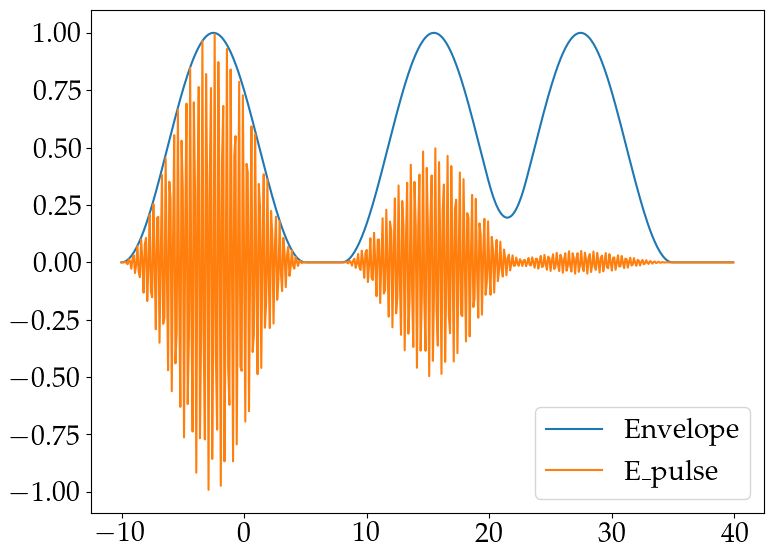

Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.


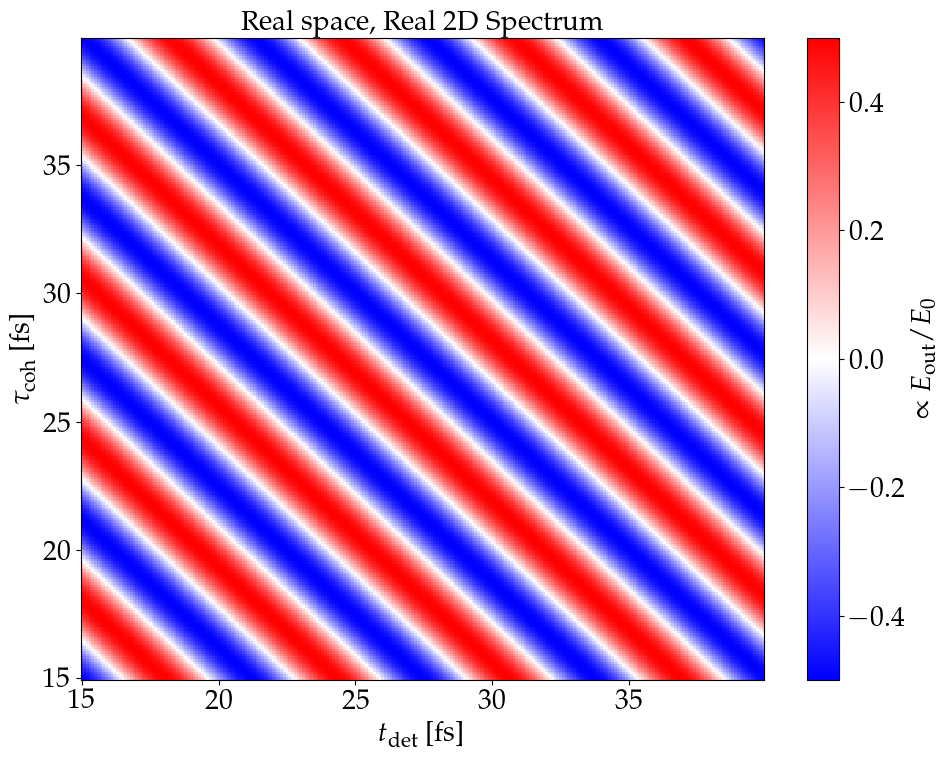

Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.


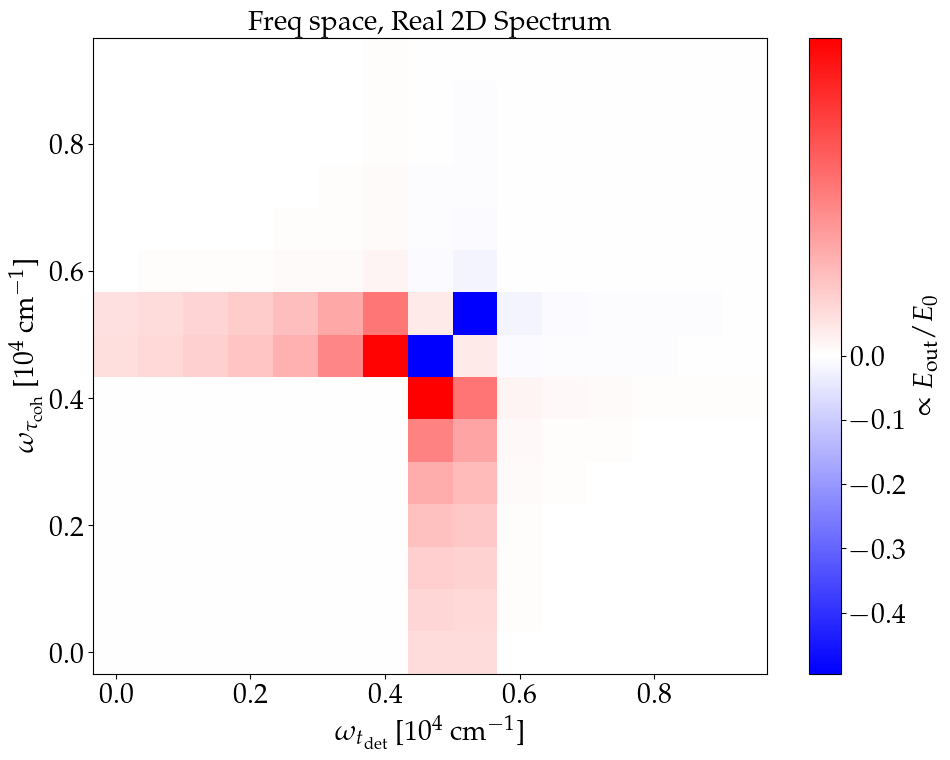

In [ ]:
# =============================
# THIS FILE IS MAINLY FOR TESTING
# =============================


### Phase Cycling for Averaging
phases = [k * np.pi / 2 for k in range(4)]

# =============================
# Example: How to use PulseSequence with SystemParameters
# =============================

# Assume test_params is an instance of SystemParameters
test_params = SystemParameters(
    N_atoms=1,
    ODE_Solver="Paper_eqs",
    RWA_laser=True,
    Delta_cm=200.0,
    omega_A_cm=16000.0,
    mu_eg_cm=1.0,
    omega_laser_cm=16000.0,
    E0=0.1,
    pulse_duration=15.0,
    t_max=40.0,
    fine_spacing=0.1,
    gamma_0=1/200,
    T2=80.0
)
test_params.summary()

test_times = np.arange(-10, test_params.t_max, test_params.fine_spacing)
test_pulse_phases = [np.pi / 2, 0, np.pi / 4]
test_pulse_amps   = [2.0, 1.0, 0.1]

# Use SystemParameters to generate pulses
pulses = [
    Pulse(
        pulse_start_time = t,
        pulse_half_width = test_params.pulse_duration / 2,
        pulse_phase      = phi,
        pulse_amplitude  = amp,
        pulse_freq       = 2 * np.pi * test_params.omega_laser
    )
    for t, phi, amp in zip(
        [test_times[0], test_times[-1]/5, test_times[-1]/2],
        test_pulse_phases,
        test_pulse_amps
    )
]

pulse_seq = PulseSequence(pulses=pulses)

# Example usage:
y0 = El_field_3_pulses(test_times, pulse_seq, f=pulse_envelope)
y1 = El_field_3_pulses(test_times, pulse_seq, f=Epsilon_pulse)

plt.plot(test_times, y0, label="Envelope")
plt.plot(test_times, y1, label="E_pulse")
plt.legend()
plt.show()

# =============================
# TEST: plot_positive_color_map with cos(x)*sin(y)
# =============================
x      = test_times
y      = test_times
X, Y   = np.meshgrid(x, y)
data   = np.cos(X) * np.sin(Y)

plot_positive_color_map(
    datas=(x, y, data),
    space="real",
    type="real",
    positive=True,
    use_custom_colormap=True,
)
xfreq, yfreq, datafreq = compute_2d_fft_wavenumber(x, y, data)

plot_positive_color_map(
    datas=(xfreq, yfreq, datafreq),
    space="freq",
    type="real",
    positive=True,
    use_custom_colormap=True,
    section=(0, 1,
             0, 1)
)



In [24]:
# define all the parameters for the system
test_params = SystemParameters(
    N_atoms=1,
    ODE_Solver="Paper_eqs",
    RWA_laser=True,
    Delta_cm=200.0,
    omega_A_cm=16000.0,
    mu_eg_cm=1.0,
    omega_laser_cm=16000.0,
    E0=0.1,
    pulse_duration=15.0,
    t_max=600.0,        # -> determines Δω ∝ 1/t_max
    fine_spacing=0.1,   # -> determines ω_max ∝ 1/Δt
    gamma_0=1/200,
    T2=80.0
)
print(test_params.summary())

t_max_test = test_params.t_max 
fine_spacing_test = test_params.fine_spacing

test_Delta_ts = test_params.Delta_ts
times_test = np.arange(-test_Delta_ts[0], t_max_test, fine_spacing_test)
print("times: ", times_test[0], times_test[1],"...",  times_test[-1], "len", len(times_test))

=== SystemParameters Summary ===
N_atoms             : 1
ODE_Solver          : Paper_eqs
RWA_laser           : True
Delta_cm            : 200.0
omega_A_cm          : 16000.0
mu_eg_cm            : 1.0
omega_laser_cm      : 16000.0
E0                  : 0.1
pulse_duration      : 15.0
t_max               : 600.0
fine_spacing        : 0.1
gamma_0             : 0.005
T2                  : 80.0
psi_ini             : Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]]
--- Derived Quantities ---
rabi_0              : 0.1
delta_rabi          : 0.0
rabi_gen            : 0.1
t_prd               : 62.83185307179586
fine_spacing        : 0.1
t_max               : 600.0

Dipole operator (Dip_op):
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]]

Expectation operator labels (e_ops_labels):
['gg', 'ge', 'eg', 'ee']
None
times:  -7.5 -7.4 ... 599.8999999999978 len 6075


Checking 'Paper_eqs' solver 
Checks passed. Solver appears to be called correctly, and density matrix remains Hermitian and positive.
the evolution is actually unphisical after: inf fs
True


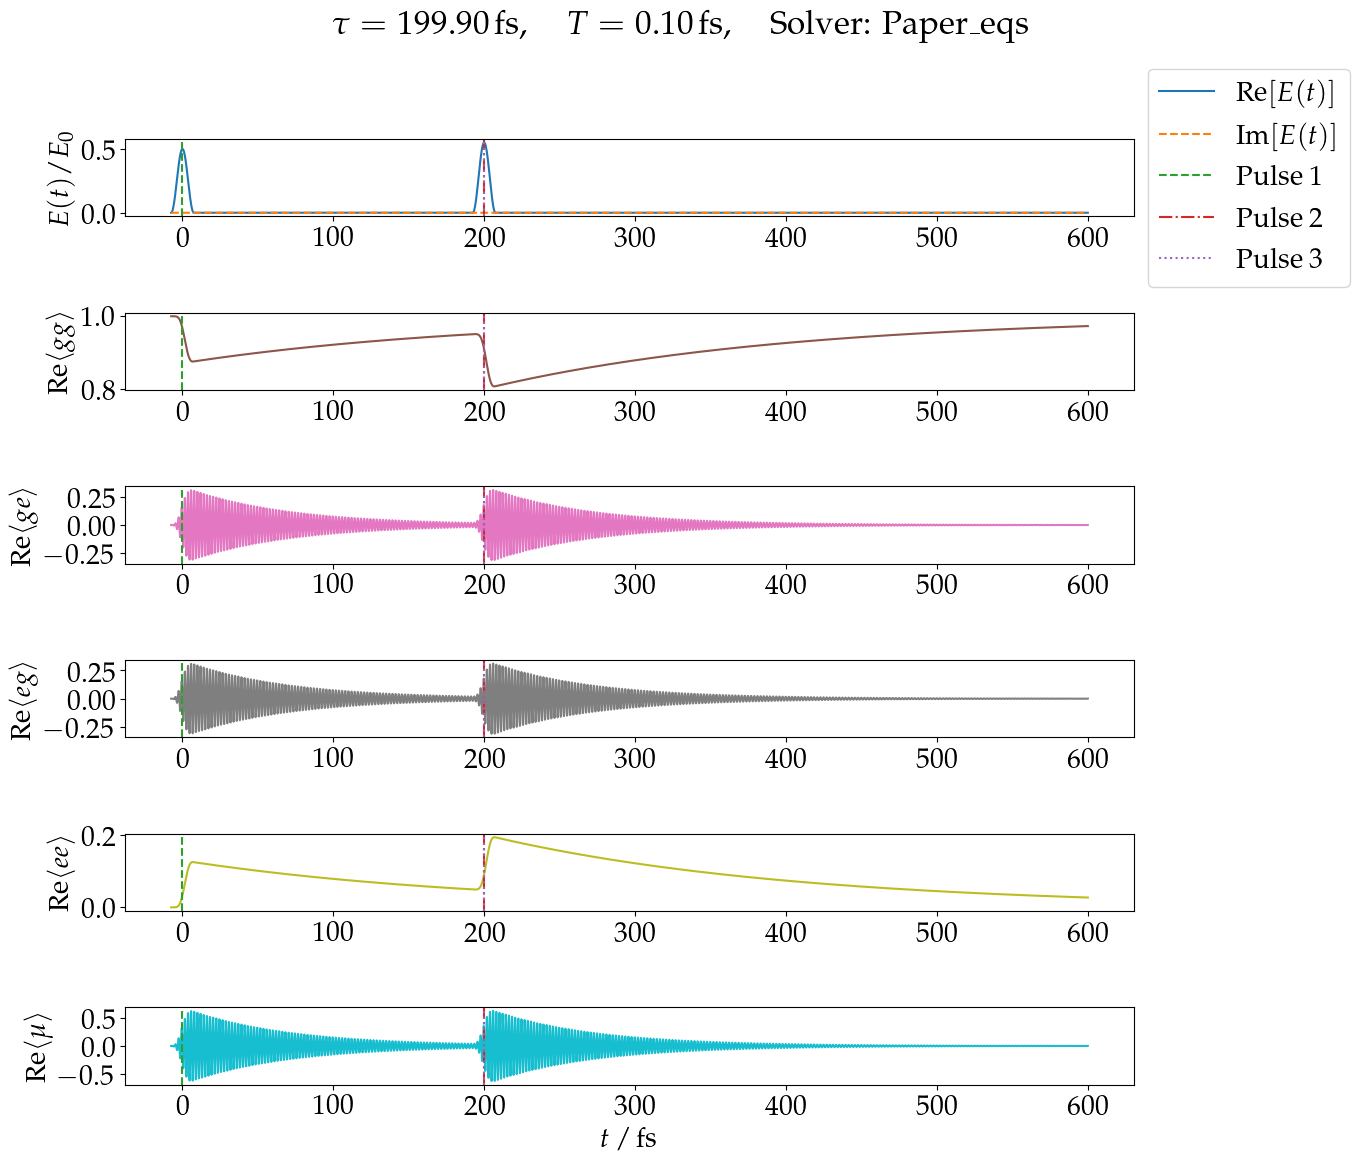

In [31]:
test_params_copy         = copy.deepcopy(test_params)
if 'time_cut' not in globals() or test_params_copy.t_max != test_params.t_max:
    # =============================
    # ALWAYS CHECK Before running a serious simulation
    # =============================
    test_params_copy.t_max   = 10 * t_max_test
    test_params_copy.fine_spacing = 10 * fine_spacing_test
    times_test_              = np.arange(-test_Delta_ts[0], test_params_copy.t_max, test_params_copy.fine_spacing)
    result, time_cut         = check_the_solver(times_test_, test_params_copy)
    print("the evolution is actually unphisical after:", time_cut, "fs")

In [32]:
T_wait_test = 1* (times_test_[1]- times_test_[0])
data_test_0 = compute_two_dimensional_polarization(T_wait_test, phases[0], phases[0], times=times_test_, system=test_params_copy,   plot_example=True)
#data_test_1 = compute_many_polarizations(T_wait_test, phases[0], phases[0], times=times_test_, N=10, E0=omega_A, Delta=Delta)

Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.


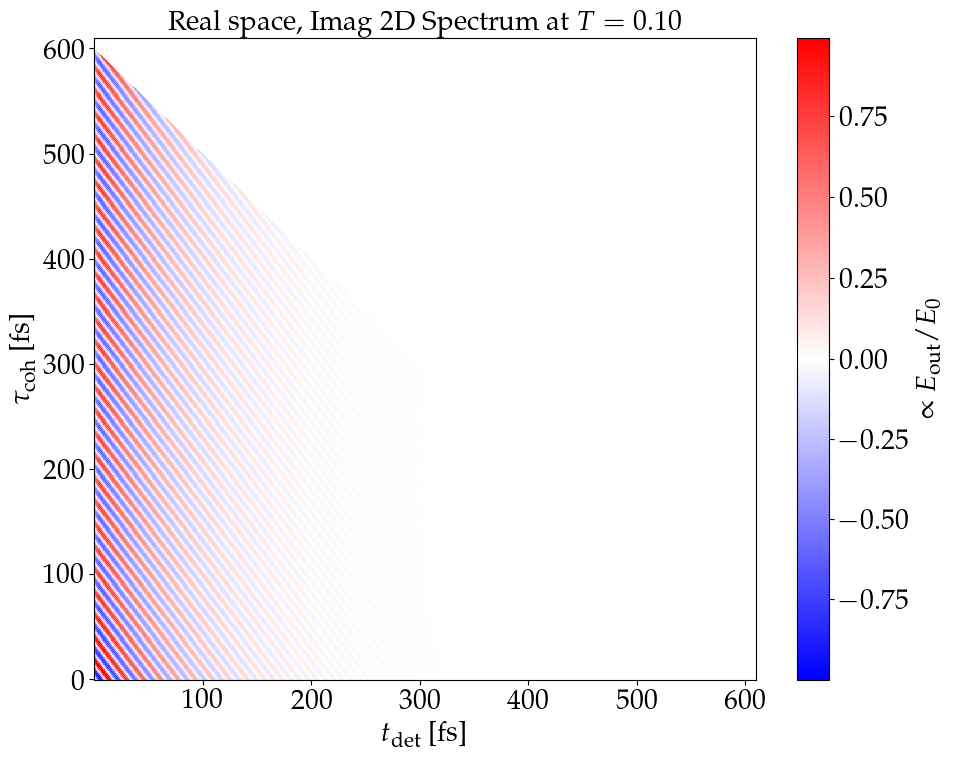

Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.


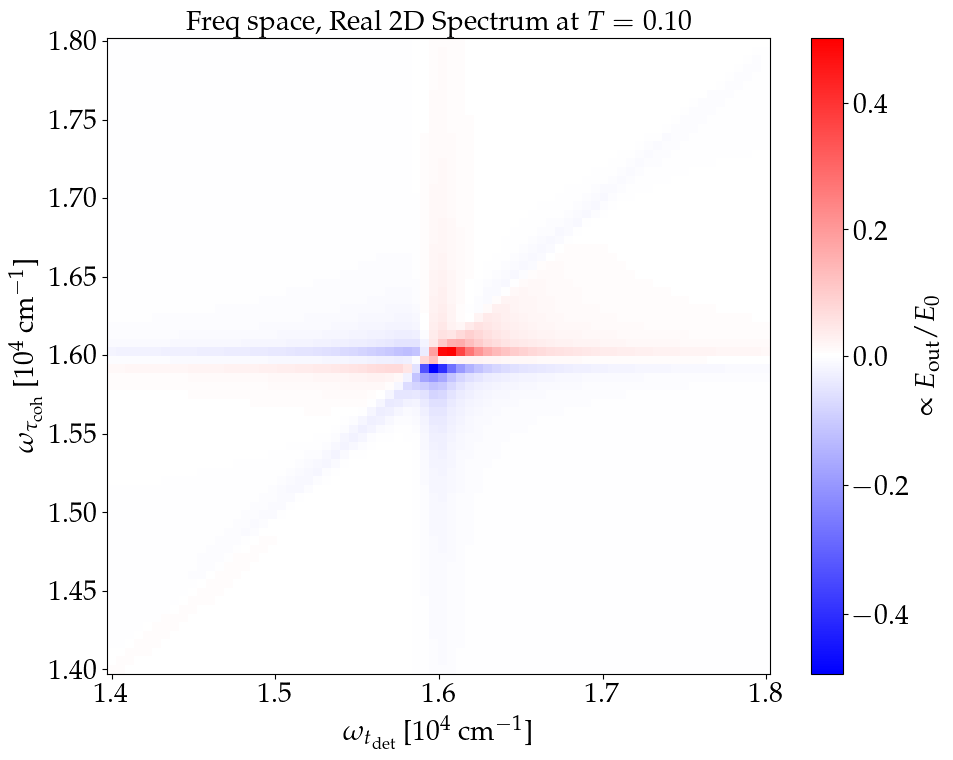

In [33]:
plot_args_freq = dict(                   # (**changeable**) 
    space="freq",                   
    type="real",                    # plot the real part (also "imag", "phase", "abs")
    safe=False,                     # (dont) save the spectrum
    positive=True,                  # only plot the positive spectrum
    use_custom_colormap=True,# all zeros are white
    section=(                       # focus on the non zero part
        1.4, 1.8, # xmin, xmax,
        1.4, 1.8, # ymin, ymax
        ),

    # add more options as needed
)

ts, taus, data = data_test_0[0], data_test_0[1], data_test_0[2]
#ts, taus, data, omega_samples = data_test_1[0], data_test_1[1], data_test_1[2], data_test_1[3]

extend_for = (0, 100)
ts, taus, data = extend_time_tau_axes(ts, taus, data, pad_rows=extend_for, pad_cols=extend_for)
plot_positive_color_map(
    (ts, taus, data),
    type="imag", # because E ~ i*P
    T_wait=T_wait_test, 
    safe=False,
    use_custom_colormap=True,
)

nu_ts, nu_taus, s2d = compute_2d_fft_wavenumber(ts, taus, data)
plot_positive_color_map(
    (nu_ts, nu_taus, s2d),
    T_wait=T_wait_test, 
    **plot_args_freq
)

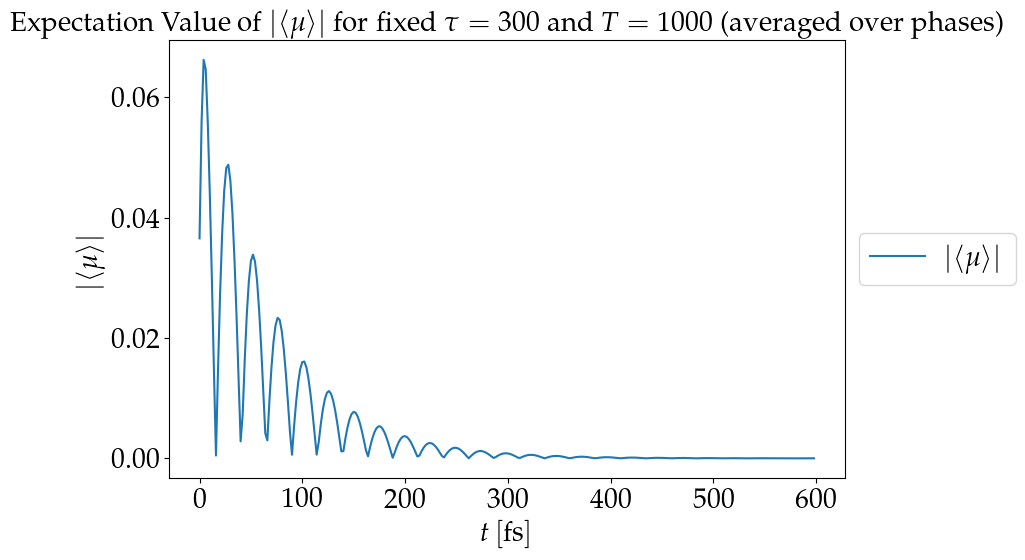

In [34]:
def compute_fixed_tau_T(
    tau_coh: float,
    T_wait: float,
    phi_0: float,
    phi_1: float,
    times: np.ndarray,
    system: SystemParameters,
    **kwargs,
):
    """
    Compute the data for a fixed tau_coh and T_wait.

    Parameters
    ----------
    tau_coh : float
        Coherence time.
    T_wait : float
        Waiting time.
    phi_0 : float
        Phase of the first pulse.
    phi_1 : float
        Phase of the second pulse.
    times : np.ndarray
        Time array for the simulation.
    system : SystemParameters
        System parameters object.

    Returns
    -------
    tuple
        (t_det_vals, data) where t_det_vals are the detection times (shifted to start at zero)
        and data is the corresponding computed observable.
    """

    idx_start_0 = 0
    t_start_0 = times[idx_start_0]  # ALWAYS the starting point of the first pulse
    idx_end_0 = np.abs(times - (system.Delta_ts[0])).argmin()
    idx_start_1 = np.abs(times - (tau_coh - system.Delta_ts[1])).argmin()

    t_start_1 = times[idx_start_1]  # Start time of the second pulse

    times_0 = times[
        : idx_start_1 + 1
    ]  # definetly not empty except for when T_wait >= t_max
    if times_0.size == 0:
        times_0 = times[: idx_end_0 + 1]

    # calculate the evolution of the first pulse in the desired range for tau_coh

    # First pulse
    pulse_0 = (t_start_0, phi_0)
    # Instead of directly constructing PulseSequence, use from_args:
    pulse_seq_0 = PulseSequence.from_args(
        system=system,
        curr=pulse_0,
    )
    data_0 = compute_pulse_evolution(
        system.psi_ini, times_0, pulse_seq_0, system=system
    )

    rho_1 = data_0.states[idx_start_1]

    idx_end_1 = np.abs(
        times - (tau_coh + system.Delta_ts[1])
    ).argmin()  # index at which the second pulse ends
    # Take the state (after / also during) the first pulse and evolve it with the second (and potentially overlaped first) pulse

    # select range  ->  to reduce computation time
    idx_start_2 = np.abs(times - (tau_coh + T_wait - system.Delta_ts[2])).argmin()
    t_start_2 = times[idx_start_2]  # the time at which the third pulse starts
    idx_end_2 = np.abs(
        times - (tau_coh + T_wait + system.Delta_ts[2])
    ).argmin()  # end of the third pulse
    # idx_start_2_0 = np.abs(times - (T_wait - Delta_ts[2])).argmin() # the first time at which the third pulse starts

    times_1 = times[
        idx_start_1 : idx_start_2 + 1
    ]  # like this: also take the overlap into account;

    if times_1.size == 0:
        times_1 = times[idx_start_1 : idx_end_1 + 1]

    # Handle overlapping pulses: If the second pulse starts before the first pulse ends, combine their contributions
    pulse_1 = (t_start_1, phi_1)
    pulse_seq_1 = PulseSequence.from_args(
        system=system,
        curr=pulse_1,
        prev=pulse_0,
    )
    data_1 = compute_pulse_evolution(rho_1, times_1, pulse_seq_1, system=system)

    idx_start_2_in_times_1 = np.abs(times_1 - (t_start_2)).argmin()

    rho_2 = data_1.states[
        idx_start_2_in_times_1
    ]  # == state where the third pulse starts

    times_2 = times[
        idx_start_2:
    ]  # the rest of the evolution (third pulse, potentially overlapped with previouses) # can be empty, if tau_coh + T_wait >= t_max
    # print(len(times), len(times_0), len(times_1), len(times_2))
    if times_2.size == 0:
        times_2 = [times[idx_start_2]]
    # If the second pulse starts before the first pulse ends, combine their contributions
    phi_2 = 0  # FIXED PHASE!
    pulse_f = (t_start_2, phi_2)
    pulse_seq_f = PulseSequence.from_args(
        system=system,
        curr=pulse_f,
        prev=pulse_1,
        preprev=pulse_0,
    )
    data_f = compute_pulse_evolution(rho_2, times_2, pulse_seq_f, system=system)

    t_det_start_idx_in_times_2 = np.abs(
        times_2 - (times_2[0] + system.Delta_ts[2])
    ).argmin()  # detection time index in times_2
    t_last_pulse_peak = times_2[t_det_start_idx_in_times_2]
    # only if we are still in the physical regime
    states = data_f.states[t_det_start_idx_in_times_2:]
    t_det_vals = data_f.times[t_det_start_idx_in_times_2:]
    data = np.zeros(
        (len(t_det_vals)), dtype=np.complex64
    )  # might get uncontrollable big!TODO

    # print(t_det_vals[0], t_det_vals[1], t_det_vals[-1], len(t_det_vals))

    if system.RWA_laser:
        states = [
            apply_RWA_phase_factors(state, time, omega=system.omega_laser)
            for state, time in zip(states, t_det_vals)
        ]

    for t_idx, t_det in enumerate(t_det_vals):
        if t_det < time_cut:
            data[:] = np.real(expect(system.Dip_op, states[:]))
    return np.array(t_det_vals) - t_det_vals[0], data


# Plot the data for a fixed tau_coh and T_wait
def plot_fixed_tau_T(
    tau_coh: float,
    T_wait: float,
    phi_0: float,
    phi_1: float,
    times: np.ndarray,
    system: SystemParameters,
):
    """
    Plot the data for a fixed tau_coh and T.

    Parameters
    ----------
    tau_coh : float
        Coherence time.
    T_wait : float
        Waiting time.
    phi_0 : float
        Phase of the first pulse.
    phi_1 : float
        Phase of the second pulse.
    times : np.ndarray
        Time array for the simulation.
    system : SystemParameters
        System parameters object.
    """
    t_det_vals, data = compute_fixed_tau_T(
        tau_coh, T_wait, phi_0, phi_1, times, system=system
    )

    plt.figure(figsize=(10, 6))
    plt.plot(
        t_det_vals,
        np.real(data),
        label=r"$|\langle \mu \rangle|$",
        color="C0",
        linestyle="solid",
    )
    plt.xlabel(r"$t \, [\text{fs}]$")
    plt.ylabel(r"$|\langle \mu \rangle|$")
    plt.title(
        rf"Expectation Value of $|\langle \mu \rangle|$ for fixed $\tau={tau_coh}$ and $T={T_wait}$"
    )
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()


def compute_average_fixed_tau_T(
    tau_coh: float,
    T_wait: float,
    times: np.ndarray,
    phases: list,
    system: SystemParameters,
):
    """
    Compute the average data for a fixed tau_coh and T_wait over all phase combinations.

    Parameters
    ----------
    tau_coh : float
        Coherence time.
    T_wait : float
        Waiting time.
    times : np.ndarray
        Time array for the simulation.
    phases : list
        List of phase values.
    system : SystemParameters
        System parameters object.

    Returns
    -------
    tuple
        (t_det_vals, data_avg)
    """
    results = []
    for phi_0 in phases:
        for phi_1 in phases:
            try:
                result = compute_fixed_tau_T(
                    tau_coh, T_wait, phi_0, phi_1, times=times, system=system
                )
                results.append(result)
            except Exception as e:
                print(f"Error in computation for phi_0={phi_0}, phi_1={phi_1}: {e}")
                raise

    t_det_vals = results[0][0]  # Time values are the same for all computations
    data_sum = np.zeros_like(results[0][1], dtype=complex)
    for _, data in results:
        data_sum += data
    data_avg = data_sum / len(results)

    return t_det_vals, data_avg

def plot_average_fixed_tau_T(
    tau_coh: float,
    T_wait: float,
    times: np.ndarray,
    phases: list,
    system: SystemParameters,
):
    """
    Plot the averaged data for a fixed tau_coh and T_wait over all phase combinations.

    Parameters
    ----------
    tau_coh : float
        Coherence time.
    T_wait : float
        Waiting time.
    times : np.ndarray
        Time array for the simulation.
    phases : list
        List of phase values.
    system : SystemParameters
        System parameters object.

    Returns
    -------
    None
    """
    t_det_vals, data_avg = compute_average_fixed_tau_T(
        tau_coh, T_wait, times, phases, system=system
    )

    plt.figure(figsize=(10, 6))
    plt.plot(
        t_det_vals,
        np.abs(data_avg),
        label=r"$|\langle \mu \rangle|$",
        color="C0",
        linestyle="solid",
    )
    plt.xlabel(r"$t \, [\text{fs}]$")
    plt.ylabel(r"$|\langle \mu \rangle|$")
    plt.title(
        rf"Expectation Value of $|\langle \mu \rangle|$ for fixed $\tau={tau_coh}$ and $T={T_wait}$ (averaged over phases)"
    )
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

def compute_average_fixed_tau_T_over_omega_ats(
    tau_coh: float,
    T_wait: float,
    times: np.ndarray,
    phases: list,
    omega_ats: list,
    system: SystemParameters,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute the average data for a fixed tau_coh and T_wait over all phase combinations
    and a list of omega_ats (inhomogeneous broadening).

    Parameters
    ----------
    tau_coh : float
        Coherence time.
    T_wait : float
        Waiting time.
    times : np.ndarray
        Time array for the simulation.
    phases : list
        List of phase values.
    omega_ats : list
        List of omega_A_cm values to average over.
    system : SystemParameters
        System parameters object.

    Returns
    -------
    tuple
        (t_det_vals, data_avg) where data_avg is averaged over all omega_ats and phase combinations.
    """
    all_results = []

    # =============================
    # Loop over all omega_ats
    # =============================
    for omega_at in omega_ats:
        system_new = copy.deepcopy(system)
        system_new.omega_A_cm = omega_at
        t_det_vals, data_avg = compute_average_fixed_tau_T(
            tau_coh, T_wait, times, phases, system=system_new
        )
        all_results.append(data_avg)

    # =============================
    # Average over all omega_ats
    # =============================
    data_avg_over_omega = np.mean(np.stack(all_results), axis=0)

    return t_det_vals, data_avg_over_omega

# Test the function and plot the data
t_max_test = 1900
fine_spacing_test = 20
times_test = np.arange(
    -test_params.Delta_ts[0], t_max_test, fine_spacing_test
)  # High-resolution times array to do the evolutions
tau_coh_test = 300
T_wait_test = 1000

# plot_fixed_tau_T(tau_coh_test, T_wait_test, phases[0], phases[1], times=times_test)
# plot_average_fixed_tau_T(
#    tau_coh_test, T_wait_test, times_test, phases, system=test_params
#)

omega_ats = sample_from_sigma(N=10, Delta=test_params.Delta, E0=test_params.omega_A)
t_det_vals, data_avg = compute_average_fixed_tau_T_over_omega_ats(
    tau_coh_test, T_wait_test, times_test, phases, omega_ats, system=test_params
)

plt.figure(figsize=(10, 6))
plt.plot(t_det_vals, np.abs(data_avg), label=r"$|\langle \mu \rangle|$ (avg over $\omega_A$)", color="C1", linestyle="dashed")
plt.xlabel(r"$t \, [\text{fs}]$")
plt.ylabel(r"$|\langle \mu \rangle|$")
plt.title(rf"Expectation Value of $|\langle \mu \rangle|$ for fixed $\tau={tau_coh_test}$ and $T={T_wait_test}$ (avg over $\omega_A$ and phases)")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
# Test the function and plot the data
t_max_test     = 100 # -> determines Δω
fine_spacing_test = 0.1 # -> determines ω_max
times_test     = np.arange(-Delta_ts[0], t_max_test, fine_spacing_test)
print("times: ", times_test[0], times_test[1],"...",  times_test[-1], "len", len(times_test))
times_T_test = (np.array([0])# , 16, 30, 46, 62, 108, 140, 310])
)  # np.arange(T_wait_0, last_entry, sparse_spacing)

RESULT = parallel_process_all_combinations(phases ,times_T=times_T_test, times=times_test)

In [ ]:
# Example usage
extend_and_plot_results(RESULT, times_T=times_T_test, times=times_test, extend_for=extend_for, **plot_args_freq)